# Setting up Kaggle Directory![vgg architecture.png](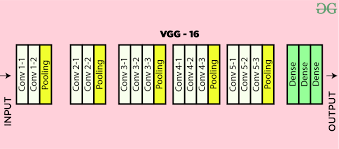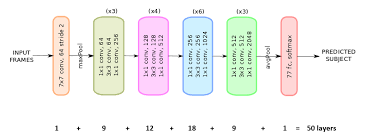)

Create a directory named ".kaggle" in your home directory.

Copy the file named "kaggle.json" into the newly created ".kaggle" directory.

These commands are useful for setting up direct access to Kaggle datasets from Google Colab. After creating an API token on Kaggle (from your account settings), save it in a file named "kaggle.json". Then, by running these commands, you'll configure Kaggle access in Colab.


In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


You can get this API token by clicking on "Three Dots" in the dataset interface and selecting "Copy API Command".


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013

License(s): DbCL-1.0


 91% 55.0M/60.3M [00:00<00:00, 290MB/s]

100% 60.3M/60.3M [00:00<00:00, 286MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.

  inflating: /content/train/sad/Training_65242339.jpg  

  inflating: /content/train/sad/Training_65267116.jpg  

  inflating: /content/train/sad/Training_65275626.jpg  

  inflating: /content/train/sad/Training_6529266.jpg  

  inflating: /content/train/sad/Training_65329617.jpg  

  inflating: /content/train/sad/Training_65338712.jpg  

  inflating: /content/train/sad/Training_65338797.jpg  

  inflating: /content/train/sad/Training_65387162.jpg  

  inflating: /content/train/sad/Training_65404494.jpg  

  inflating: /content/train/sad/Training_65426218.jpg  

  inflating: /content/train/sad/Training_65430136.jpg  

  inflating: /content/train/sad/Training_65437377.jpg  

  inflating: /content/train/sad/Training_6545735.jpg  

  inflating: /content/train/sad/Training_65463385.jpg  

  inflating: /content/train/sad/Training_65473985.jpg  

  inflating: /content/train/sad/Training_65502829.jpg  

  inflating: /content/train/sad/Traini

# Installing Packages

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

This code creates a directory named "test_dir". If the directory already exists, it won't raise an error (`exist_ok=True`).


In [5]:
os.makedirs('test_dir', exist_ok=True)

We're setting up a project directory structure for a project called "FER_2013_Emotion_Detection".

**Defining Project Name:**
- We start by defining a variable `project_name` which holds the name of our project, "FER_2013_Emotion_Detection".

**Listing Models:**
- Next, we list down the models we'll be working with using the `model_names` list:
  - Custom CNN From Scratch
  - Custom CNN With Augmentation
  - VGG16 Transfer Learning
  - ResNet50 Transfer Learning

**Defining Base Directory:**
- We set the `base_dir` variable to the location of our Colab workspace, which is '/content/'.

**Creating Project Directory:**
- Using `os.path.join()`, we create the main project directory `project_dir` by combining the base directory and project name.
- `os.makedirs()` is used to create the project directory. `exist_ok=True` ensures that if the directory already exists, no error will be raised.

**Creating Model Subdirectories:**
- We iterate through each model in the `model_names` list.
- For each model, we create a subdirectory inside the project directory using `os.path.join()`.
- Again, `os.makedirs()` is used to create the model subdirectories.

**Printing Confirmation:**
- Finally, we print a message confirming that the project directory structure has been successfully created.


In [6]:
# Define your project name
project_name = 'FER_2013_Emotion_Detection'

# List your models
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory (in this case, your Google Colab workspace)
base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)
    # Example subdirectories for model-related files
    # os.makedirs(os.path.join(model_dir, 'checkpoints'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'logs'), exist_ok=True)
    # os.makedirs(os.path.join(model_dir, 'saved_models'), exist_ok=True)

print(f'Project directory structure created at: {project_dir}')


Project directory structure created at: /content/FER_2013_Emotion_Detection


# Data Cleaning

**Code Overview:**

This code block iterates through a directory containing image files and filters out any files that are not in the specified list of acceptable image extensions. It also handles exceptions that may occur during file processing.

**Define List of Acceptable Image Extensions:**
- We start by defining a list `image_exts` containing acceptable image file extensions such as JPEG, JPG, and PNG.

**Set Path to Data Directory:**
- The variable `data_dir` holds the path to the directory containing image classes and possibly nested subdirectories. In this case, it's set to '/content/train'.

**Walk Through Dataset Directory:**
- We use `os.walk()` to traverse through all directories and files in the dataset directory specified by `data_dir`.

**Process Each File:**
- For each file encountered, we construct its full path using `os.path.join(root, file)`.
- We then attempt to determine the file type using `imghdr.what(file_path)`. This helps identify if the file is a valid image file.
- If the file extension is not in the allowed list (`image_exts`), we print a message indicating that the image is not in the allowed extension list and remove the file using `os.remove(file_path)`.
- If the file is a valid image, we can proceed with further processing. For example, reading the image using OpenCV (`cv2.imread(file_path)`).

**Handling Exceptions:**
- We catch any exceptions that occur during file processing using a try-except block.
- If an exception occurs, we print a message indicating the issue and the path of the problematic file (`file_path`).
- Optionally, we can remove files that cause exceptions using `os.remove(file_path)`.


In [7]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

## Define a Function to Count Files in Subdirectories:
- This code defines a function named `count_files_in_subdirs` to count the number of files (assumed to be images) in each subdirectory of a given directory. The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').

### Function Explanation:
- The function takes two parameters: `directory` (the directory path) and `set_name` (the name of the dataset set).
- It initializes an empty dictionary named `counts` to hold the count of files for each subdirectory.
- It iterates over each item in the given directory using `os.listdir(directory)`.
- For each item, it constructs the full path to the item using `os.path.join(directory, item)`.
- If the item is a directory (checked using `os.path.isdir(item_path)`), it counts the number of files in that subdirectory using `len(os.listdir(item_path))` and adds it to the `counts` dictionary.
- After counting files in all subdirectories, it converts the `counts` dictionary to a DataFrame `df` for easy viewing and analysis. The index of the DataFrame is set to the provided set name.
- Finally, it returns the DataFrame `df`.

### Counting Files in Training and Testing Directories:
- The code provides paths to the training and testing directories (`train_dir` and `test_dir`, respectively).
- It calls the `count_files_in_subdirs` function for both directories, passing the respective directory paths and set names ('train' for training and 'test' for testing).
- The counts for each directory are printed to the console.



In [8]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       surprise   sad  happy  fear  neutral  angry  disgust

train      3171  4830   7215  4097     4965   3995      436

      surprise   sad  happy  fear  neutral  angry  disgust

test       831  1247   1774  1024     1233    958      111


<Axes: >

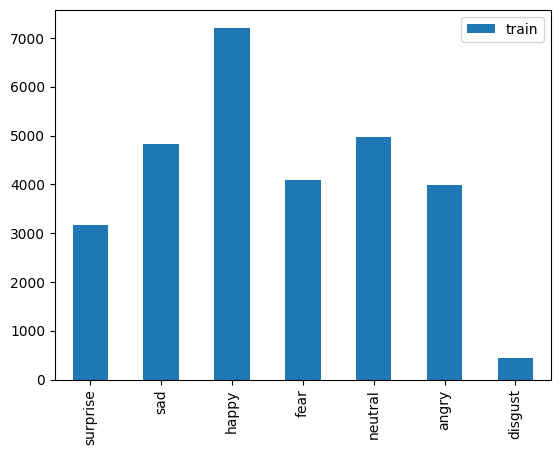

In [9]:
train_count.transpose().plot(kind='bar')

<Axes: >

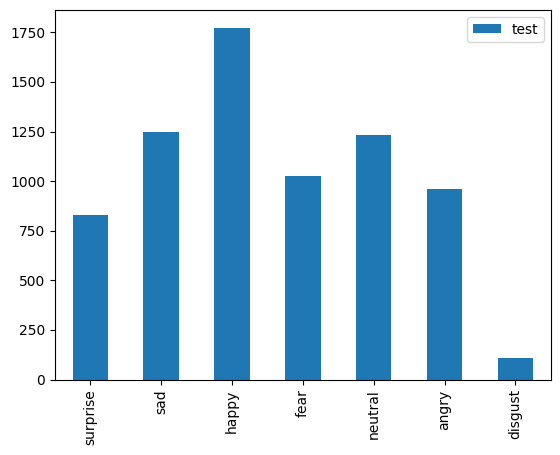

In [10]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

- The code first lists all directories in the `train_dir` directory using `os.listdir(train_dir)`. These directories represent different emotions.
- It then creates a plot using Matplotlib (`plt.figure(figsize=(15,10))`) to display images corresponding to each emotion.
- For each emotion directory, it iterates through the images in that directory.
- It constructs the path to a specific image in the emotion directory (`img_path`) using `os.path.join(folder, os.listdir(folder)[42])`. Here, `[42]` indicates a specific image index (e.g., the 42nd image).
- It reads the image using `plt.imread(img_path)` and stores it in the variable `img`.
- It plots the image using `plt.imshow()` and sets the colormap to 'gray'.
- It sets the title of the subplot to the corresponding emotion (`plt.title(emotion)`).
- It turns off the axis using `plt.axis('off')` to remove the axis labels and ticks.
- This process repeats for each emotion, and the resulting plot displays images for each emotion in a grid layout.


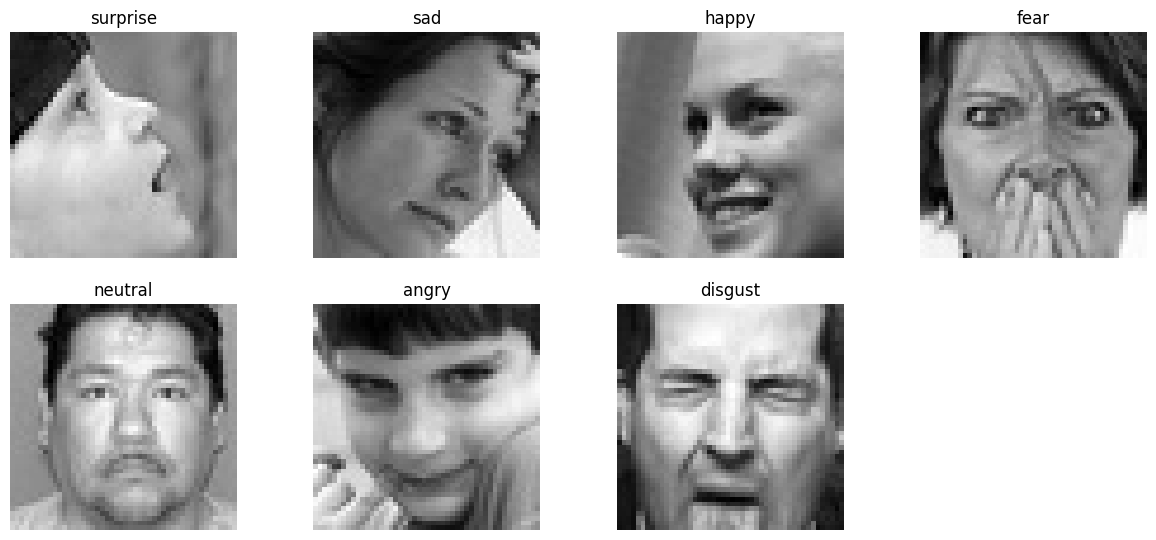

In [11]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

This function plots a specified number of images randomly selected from a directory. If the number of images in the directory is less than the requested number, it displays all available images. Each image is plotted with its corresponding class name.

The function takes three parameters:
- `directory_path`: The path to the directory containing the images.
- `class_name`: The name of the class or category associated with the images.
- `num_images` (optional): The number of images to display. Default is 9.

It first retrieves the list of all file names in the directory and randomly selects a specified number of them. Then, it plots the selected images in a grid layout using Matplotlib.


In [12]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

## Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path

This code snippet calls the `plot_images_from_directory` function to plot images from the directory specified by `angry_directory_path`. Each image will be labeled with the class name 'Angry'.

You can display images from any class by changing the directory path to the desired class directory. For example, to display images of a different class such as 'Happy', change the directory path accordingly (`'/content/train/happy'`).

Once you replace the placeholder with the correct directory path, running this code will display the images of the specified class in a grid layout using Matplotlib.


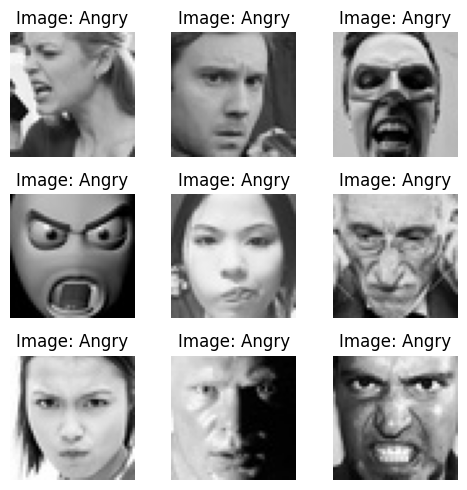

In [13]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

# Checking shapes and channels.

image = ' '

This code snippet loads an image from the specified path using OpenCV (`cv2.imread`). The image is loaded in color format by default.

If the image is loaded successfully, it prints its shape (number of rows, columns, and channels). Otherwise, it prints a message indicating that the image could not be loaded.

You can change the `image` variable to the path of any image you want to load and analyze using OpenCV.


In [14]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


image_path = ''

This code snippet loads an image from the specified path using OpenCV (`cv2.imread`). It loads the image in grayscale mode (`cv2.IMREAD_GRAYSCALE`), which means the image will have only one channel instead of three for color images.

If the image is loaded successfully, it prints its shape (number of rows, columns). For grayscale images, there is only one channel, so the shape will be (rows, columns) instead of (rows, columns, channels). Otherwise, it prints a message indicating that the image could not be loaded.

You can change the `image_path` variable to the path of any image you want to load and analyze using OpenCV.


In [15]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

In [16]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# Set some parameters
- `img_width`, `img_height`: The width and height of the images. In this case, they are set to 48x48 pixels.
- `batch_size`: The number of images to be processed in each batch during training.
- `epochs`: The number of times the entire dataset will be passed forward and backward through the neural network.
- `num_classes`: The number of classes in your dataset. You need to update this based on the number of classes you have.


In [17]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Data Generator:
A data generator is used to efficiently load and preprocess data for training neural networks in batches. It helps to manage large datasets that may not fit into memory.

# ImageDataGenerator:
The `ImageDataGenerator` class in Keras provides a way to preprocess images and generate batches of augmented data. It offers various preprocessing techniques like rescaling, rotation, shearing, etc.

# Train, Validation, and Test Generators:
- `train_generator`: Generates batches of training data. It retrieves images and their classes from the training directory specified by `train_data_dir`.
- `validation_generator`: Generates batches of validation data. It retrieves images and their classes from the same training directory but uses a validation split of 20% (`validation_split=0.2`).
- `test_generator`: Generates batches of test data. It retrieves images and their classes from the test directory specified by `test_data_dir`.

# Parameters:
- `rescale=1./255`: Rescales the pixel values of images to the [0, 1] interval by dividing each pixel value by 255.
- `validation_split=0.2`: Splits the training data into training and validation sets. Here, 20% of the training data is used for validation.
- `target_size=(img_width, img_height)`: Resizes images to the specified dimensions.
- `batch_size`: The number of images to be processed in each batch during training/validation/testing.
- `class_mode='categorical'`: Indicates that the labels are provided in categorical format.
- `color_mode='grayscale'`: Specifies that the images are in grayscale format.


In [18]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.

Found 5741 images belonging to 7 classes.

Found 7178 images belonging to 7 classes.


In [19]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# Initialising the CNN:
- `model = Sequential()`: Initializes a sequential model, which is a linear stack of layers.

# Adding Convolutional Layers:
- `model.add(Conv2D(32, kernel_size=(3, 3), kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))`: Adds a 2D convolutional layer with 32 filters, each with a 3x3 kernel size. 'glorot_uniform' is used as the kernel initializer. The 'same' padding is used to preserve the input size. The input shape is specified as (img_width, img_height, 1) for grayscale images.
- `model.add(Activation('relu'))`: Adds a ReLU activation function to the previous layer's output.
- `model.add(BatchNormalization())`: Adds a batch normalization layer to improve training stability and accelerate convergence.
- `model.add(MaxPooling2D(2, 2))`: Adds a max pooling layer with a pool size of 2x2 to downsample the feature maps.
- `model.add(Dropout(0.25))`: Adds a dropout layer to prevent overfitting by randomly setting a fraction of input units to zero during training.

# Adding More Convolutional Layers:
- Similar to the first set of convolutional layers, but with increased filter sizes (64, 128, 256, 512) and kernel regularizers (L2 regularization with a regularization strength of 0.01).

# Flattening and Adding Dense Layers:
- `model.add(Flatten())`: Flattens the 3D feature maps into a 1D vector to be fed into the fully connected (dense) layers.
- `model.add(Dense(1024))`: Adds a fully connected layer with 1024 neurons.
- `model.add(Activation('relu'))`: Adds a ReLU activation function to the dense layer.
- `model.add(Dropout(0.5))`: Adds dropout regularization to the dense layer to further prevent overfitting.

# Output Layer:
- `model.add(Dense(num_classes))`: Adds the output layer with neurons equal to the number of classes in the dataset.
- `model.add(Activation('softmax'))`: Adds a softmax activation function to the output layer to obtain class probabilities.



In [20]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [21]:
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 48, 48, 32)        320       

                                                                 

 activation (Activation)     (None, 48, 48, 32)        0         

                                                                 

 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     

                                                                 

 activation_1 (Activation)   (None, 48, 48, 64)        0         

                                                                 

 batch_normalization (Batch  (None, 48, 48, 64)        256       

 Normalization)                                                  

                                                                 

 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         

 D)                                     

# Compiling the Model:
- `model.compile(...)`: Compiles the model for training.

# Optimizer:
- `optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)`: Specifies the optimizer for training the model. Here, Adam optimizer is used with a learning rate of 0.0001.

# Loss Function:
- `loss='categorical_crossentropy'`: Specifies the loss function to be optimized during training. Categorical cross-entropy loss is commonly used for multi-class classification problems.

# Metrics:
- `metrics=['accuracy']`: Specifies the evaluation metric(s) to be used during training and testing. Here, 'accuracy' is used to monitor the performance of the model.


In [22]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

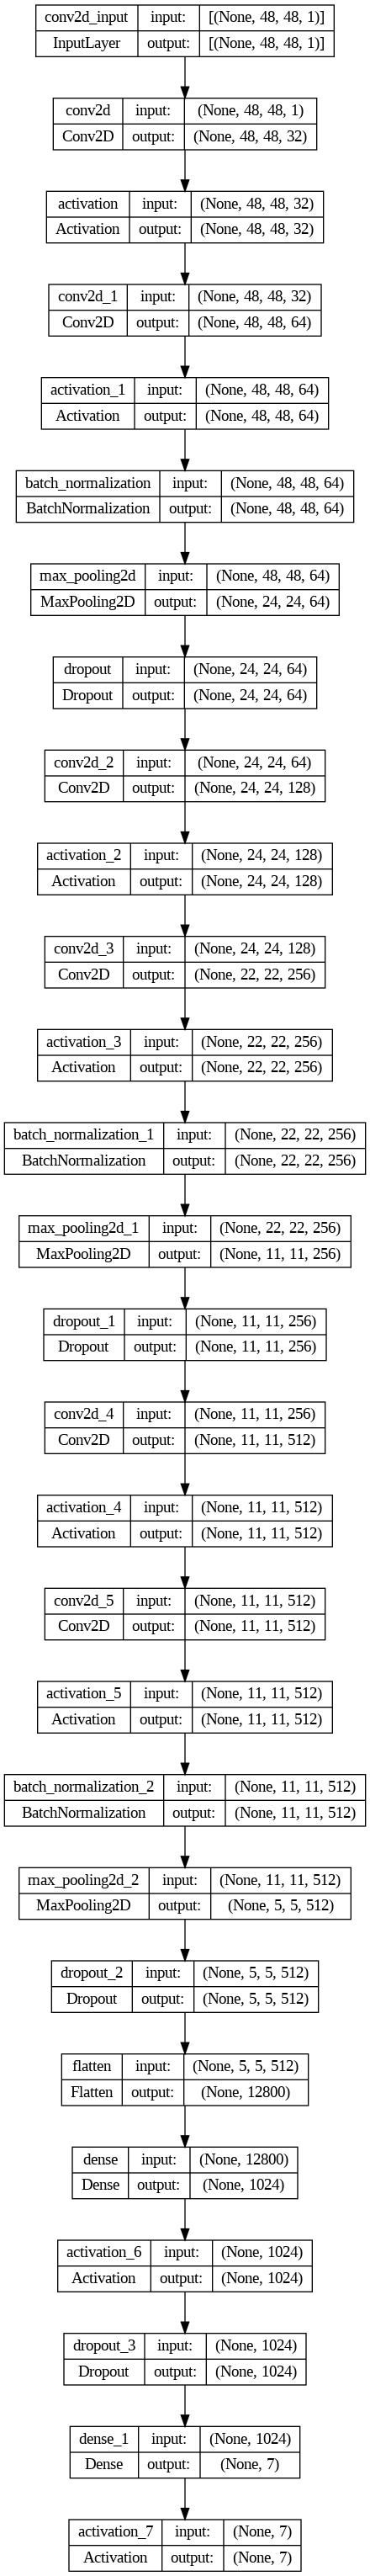

In [23]:
plot_model(model, to_file = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

# Understanding Callbacks

In [24]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

### Callback to Save the Model Checkpoint:
- `checkpoint = ModelCheckpoint(...)`: Creates a callback to save the model checkpoint during training.

### Parameters:
- `filepath=chk_path`: Specifies the path where the model checkpoints will be saved.
- `save_best_only=True`: Specifies whether to save only the best model based on the monitoring criteria.
- `verbose=1`: Specifies the verbosity mode. Here, it prints a message when a checkpoint is saved.
- `mode='min'`: Specifies the mode for monitoring the quantity to be optimized. Here, 'min' means the quantity being monitored (validation loss) should be minimized.
- `monitor='val_loss'`: Specifies the quantity to be monitored for determining the best model checkpoint. Here, it's the validation loss.


In [25]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

### Callback for Early Stopping:
- `earlystop = EarlyStopping(...)`: Creates a callback for early stopping during training.

# Parameters:
- `monitor='val_loss'`: Specifies the quantity to be monitored for early stopping. Here, it's the validation loss.
- `min_delta=0`: Specifies the minimum change in the monitored quantity to qualify as an improvement. Setting it to 0 means any decrease in validation loss will be considered an improvement.
- `patience=3`: Specifies the number of epochs with no improvement after which training will be stopped. If the validation loss does not decrease for 3 consecutive epochs, training will stop.
- `verbose=1`: Specifies the verbosity mode. Here, it prints a message when early stopping criteria are met.
- `restore_best_weights=True`: Specifies whether to restore the weights of the best model observed during training when training is stopped. Setting it to True ensures that the model with the best validation loss is saved.


In [26]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

### Callback to Reduce Learning Rate:
- `reduce_lr = ReduceLROnPlateau(...)`: Creates a callback to reduce the learning rate during training based on certain conditions.

### Parameters:
- `monitor='val_loss'`: Specifies the quantity to be monitored for reducing the learning rate. Here, it's the validation loss.
- `factor=0.2`: Specifies the factor by which the learning rate will be reduced. For example, if the current learning rate is 0.1, it will be reduced to 0.1 * 0.2 = 0.02.
- `patience=6`: Specifies the number of epochs with no improvement after which the learning rate will be reduced. If the validation loss does not decrease for 6 consecutive epochs, the learning rate will be reduced.
- `verbose=1`: Specifies the verbosity mode. Here, it prints a message when the learning rate is reduced.
- `min_delta=0.0001`: Specifies the minimum change in the monitored quantity to qualify as an improvement. It helps prevent small fluctuations in loss from triggering the learning rate reduction too early.


In [27]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

### Callback to Log Training Data to a CSV File:
- `csv_logger = CSVLogger(...)`: Creates a callback to log training data to a CSV file during training.

### Parameter:
- `os.path.join(cnn_path,'training.log')`: Specifies the path where the CSV file will be saved. The CSV file will contain training metrics such as loss and accuracy for each epoch.


In [28]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [29]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [30]:
train_generator.samples

22968

### Calculate Steps per Epoch:
- `train_steps_per_epoch`: Calculates the number of steps (batches) per epoch for training data. It ensures that all samples in the training dataset are included in the training process by dividing the total number of samples by the batch size (`train_generator.samples // train_generator.batch_size`) and adding 1 to account for any remaining samples in the last batch. This ensures that the model trains on all available data within each epoch.
- `validation_steps_epoch`: Calculates the number of steps (batches) per epoch for validation data. It follows the same logic as above for the validation generator. This ensures that the validation performance metrics are computed accurately for the entire validation dataset.
- `test_steps_epoch`: Calculates the number of steps (batches) per epoch for test data. It follows the same logic as above for the test generator. This ensures that the evaluation of the model on the test dataset covers all available samples.


In [31]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# Model Training

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10

359/359 [==============================] - ETA: 0s - loss: 12.4166 - accuracy: 0.2805

Epoch 1: val_loss improved from inf to 14.22476, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras

359/359 [==============================] - 39s 78ms/step - loss: 12.4166 - accuracy: 0.2805 - val_loss: 14.2248 - val_accuracy: 0.1918 - lr: 1.0000e-04

Epoch 2/10

359/359 [==============================] - ETA: 0s - loss: 10.1670 - accuracy: 0.3655

Epoch 2: val_loss improved from 14.22476 to 9.47125, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras

359/359 [==============================] - 34s 95ms/step - loss: 10.1670 - accuracy: 0.3655 - val_loss: 9.4713 - val_accuracy: 0.3952 - lr: 1.0000e-04

Epoch 3/10

359/359 [==============================] - ETA: 0s - loss: 8.1451 - accuracy: 0.3996

Epoch 3: val_loss improved from 9.47125 to 7.28416, saving model to /content/FER_2013_Emotion_Det

# Plotting Performance Metrics

In [33]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

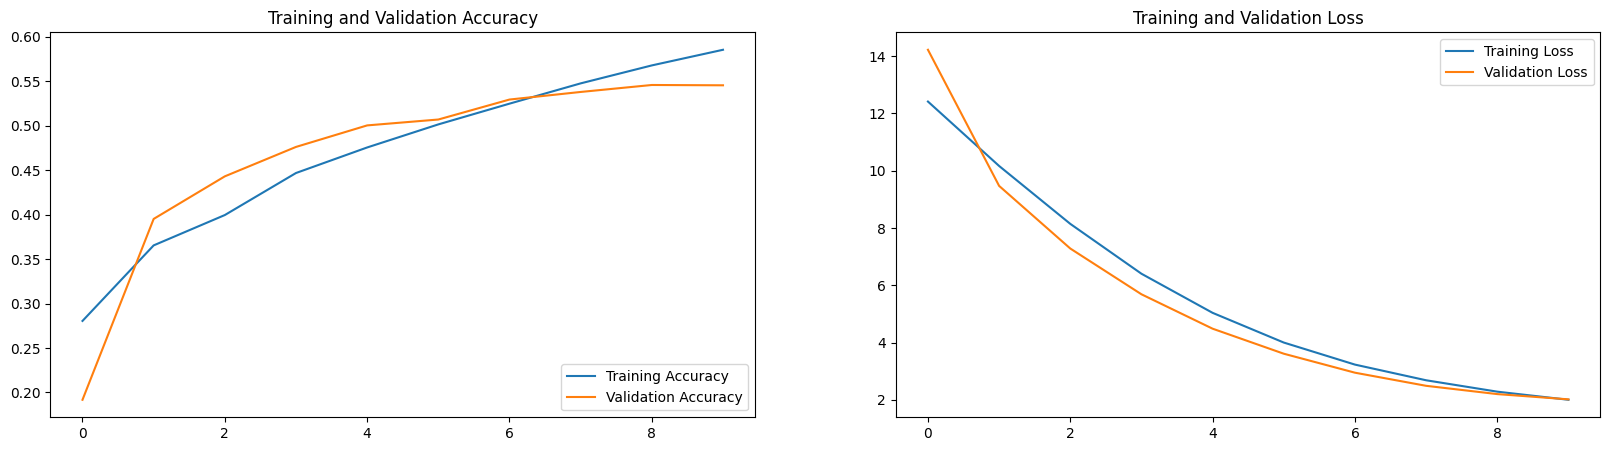

In [34]:
plot_training_history(history)

# Model Evaluation

In [35]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 [==============================] - 8s 23ms/step - loss: 1.7769 - accuracy: 0.6282

113/113 [==============================] - 3s 30ms/step - loss: 2.0027 - accuracy: 0.5542

final train accuracy = 62.82 , validation accuracy = 55.42


# Plotting Confusion Matrix

113/113 [==============================] - 3s 21ms/step


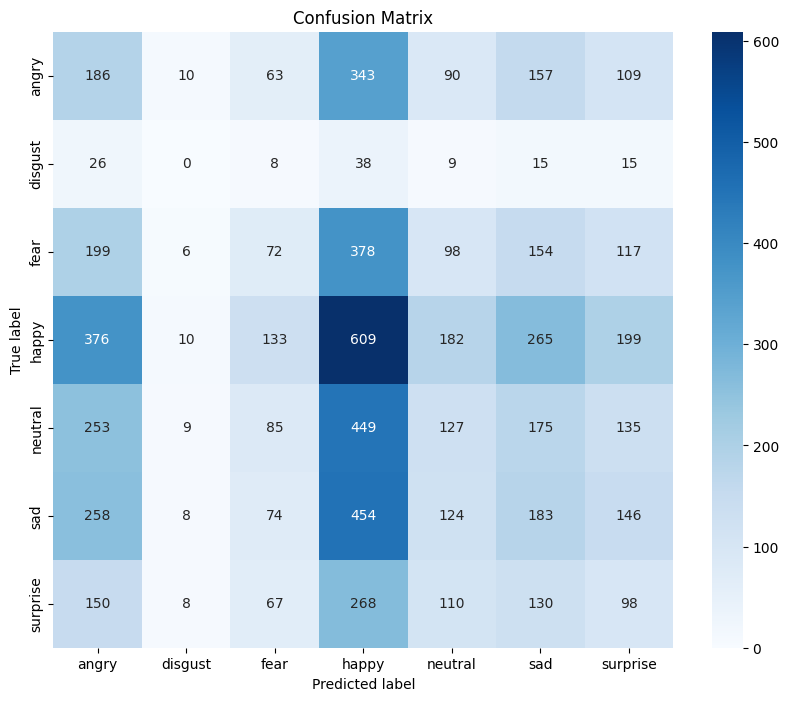

In [36]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:

               precision    recall  f1-score   support



       angry       0.13      0.19      0.15       958

     disgust       0.00      0.00      0.00       111

        fear       0.14      0.07      0.09      1024

       happy       0.24      0.34      0.28      1774

     neutral       0.17      0.10      0.13      1233

         sad       0.17      0.15      0.16      1247

    surprise       0.12      0.12      0.12       831



    accuracy                           0.18      7178

   macro avg       0.14      0.14      0.13      7178

weighted avg       0.17      0.18      0.17      7178




# Making Predictions

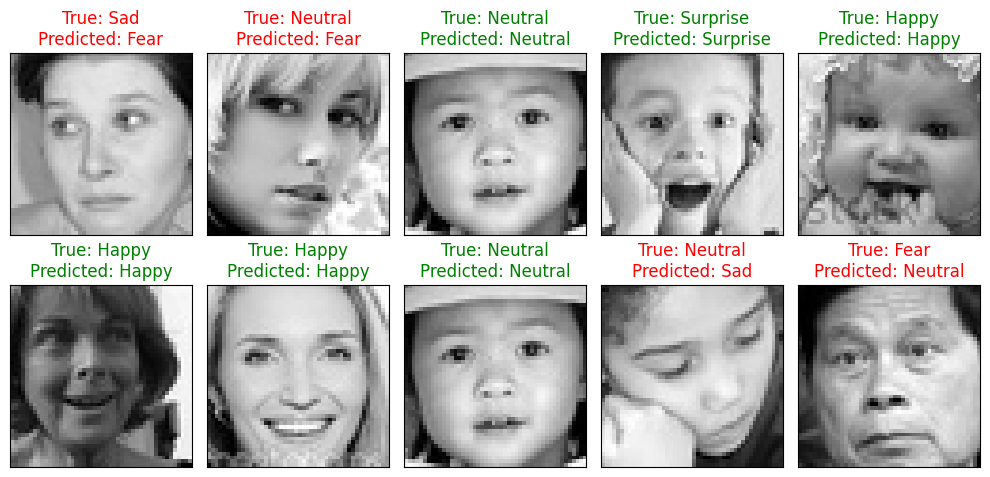

In [38]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [39]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.

Found 5741 images belonging to 7 classes.

Found 7178 images belonging to 7 classes.


In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [40]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10

359/359 [==============================] - ETA: 0s - loss: 12.4243 - accuracy: 0.2245

Epoch 1: val_loss improved from inf to 12.27960, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras

359/359 [==============================] - 37s 93ms/step - loss: 12.4243 - accuracy: 0.2245 - val_loss: 12.2796 - val_accuracy: 0.1815 - lr: 1.0000e-04

Epoch 2/10

359/359 [==============================] - ETA: 0s - loss: 10.0705 - accuracy: 0.2426

Epoch 2: val_loss improved from 12.27960 to 9.25146, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras

359/359 [==============================] - 49s 135ms/step - loss: 10.0705 - accuracy: 0.2426 - val_loss: 9.2515 - val_accuracy: 0.2515 - lr: 1.0000e-04

Epoch 3/10

359/359 [==============================] - ETA: 0s - loss: 7.8976 - accuracy: 0.2517

Epoch 3: val_loss improved from 9.25146 to 7.26067, saving model t

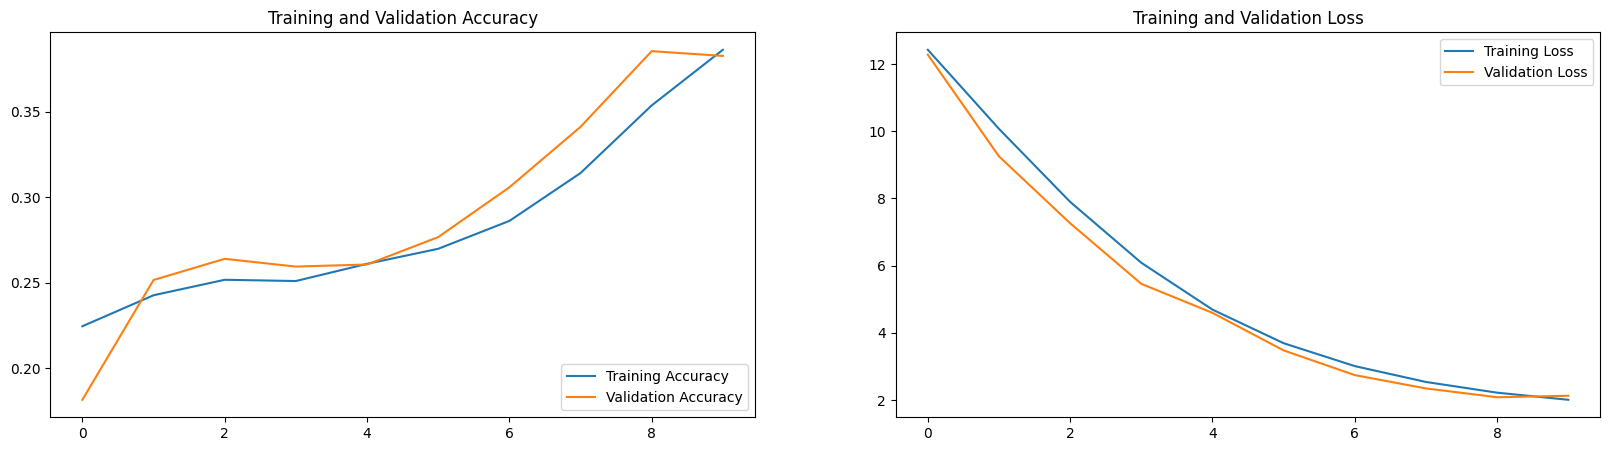

In [41]:
plot_training_history(history)

In [42]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 [==============================] - 22s 60ms/step - loss: 2.1107 - accuracy: 0.3790

113/113 [==============================] - 3s 25ms/step - loss: 2.0189 - accuracy: 0.4139

final train accuracy = 37.90 , validation accuracy = 41.39


113/113 [==============================] - 2s 21ms/step


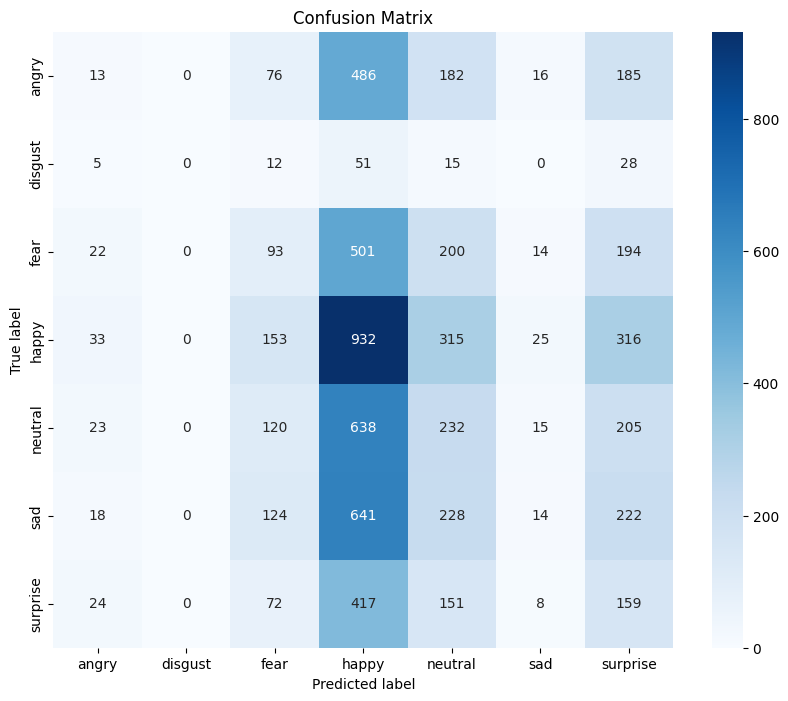

In [43]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:

               precision    recall  f1-score   support



       angry       0.09      0.01      0.02       958

     disgust       0.00      0.00      0.00       111

        fear       0.14      0.09      0.11      1024

       happy       0.25      0.53      0.34      1774

     neutral       0.18      0.19      0.18      1233

         sad       0.15      0.01      0.02      1247

    surprise       0.12      0.19      0.15       831



    accuracy                           0.20      7178

   macro avg       0.13      0.15      0.12      7178

weighted avg       0.17      0.20      0.16      7178




# Model 3: Transfer Learning VGGNET

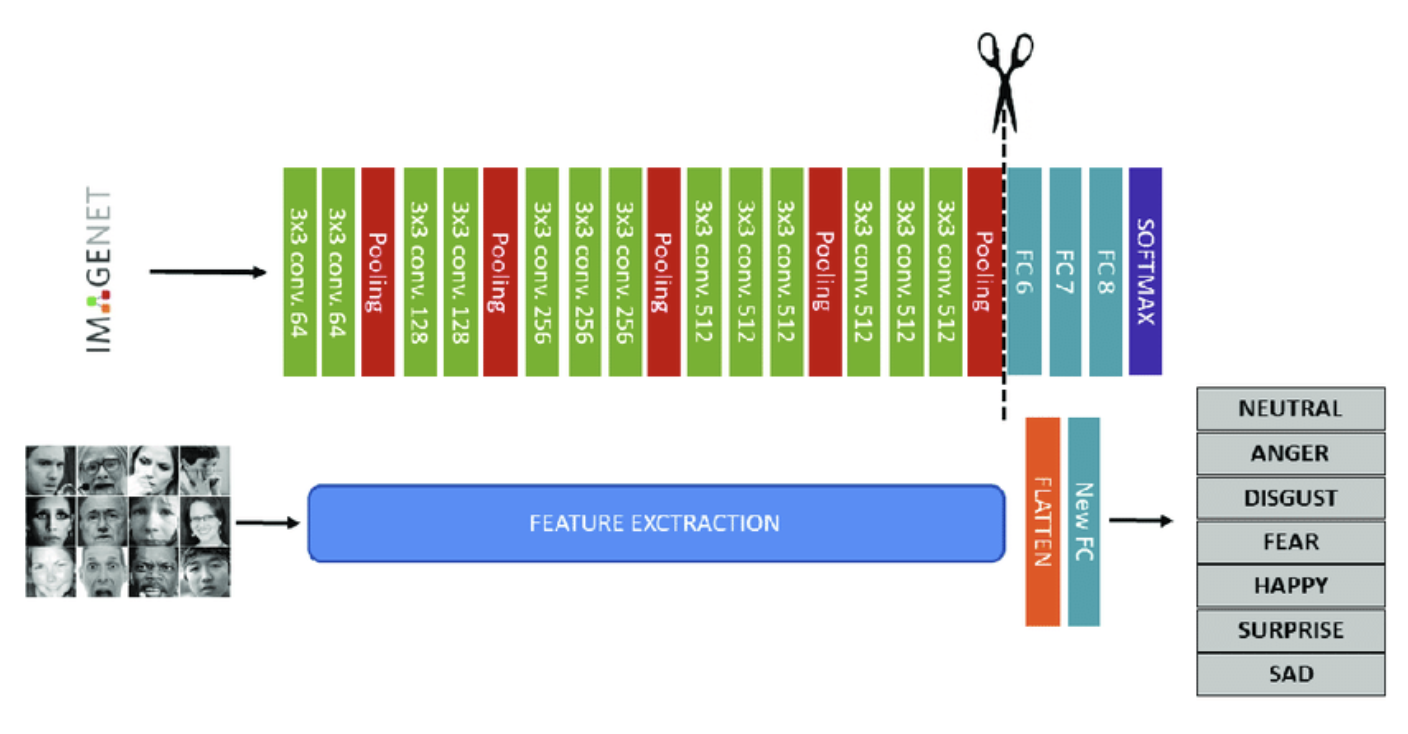

In [45]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.

Found 7178 images belonging to 7 classes.


In [46]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()


58889256/58889256 [==============================] - 0s 0us/step

Model: "vgg16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                             

In [47]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 56, 56, 1

In [48]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 56, 56, 1

In [49]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [50]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=10,
                    callbacks = callbacks)

Epoch 1/5

449/449 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.3814

Epoch 1: val_loss improved from inf to 1.40640, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras

449/449 [==============================] - 453s 973ms/step - loss: 1.5859 - accuracy: 0.3814 - val_loss: 1.4064 - val_accuracy: 0.4654 - lr: 1.0000e-04

Epoch 2/5

449/449 [==============================] - ETA: 0s - loss: 1.3650 - accuracy: 0.4797

Epoch 2: val_loss improved from 1.40640 to 1.25439, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras

449/449 [==============================] - 457s 1s/step - loss: 1.3650 - accuracy: 0.4797 - val_loss: 1.2544 - val_accuracy: 0.5203 - lr: 1.0000e-04

Epoch 3/5

449/449 [==============================] - ETA: 0s - loss: 1.2827 - accuracy: 0.5154

Epoch 3: val_loss improved from 1.25439 to 1.18360, saving model to /content/FER_2013_Emotio

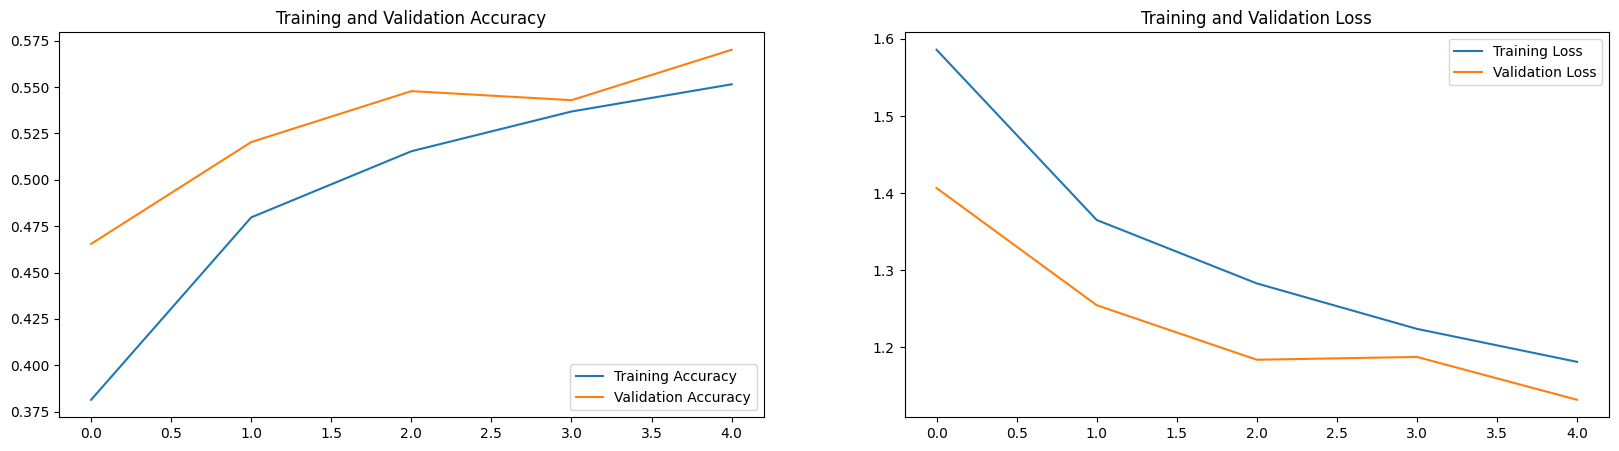

In [52]:
plot_training_history(history)

In [53]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 [==============================] - 385s 858ms/step - loss: 1.1084 - accuracy: 0.5808

113/113 [==============================] - 28s 244ms/step - loss: 1.1317 - accuracy: 0.5701

final train accuracy = 58.08 , validation accuracy = 57.01


113/113 [==============================] - 28s 245ms/step


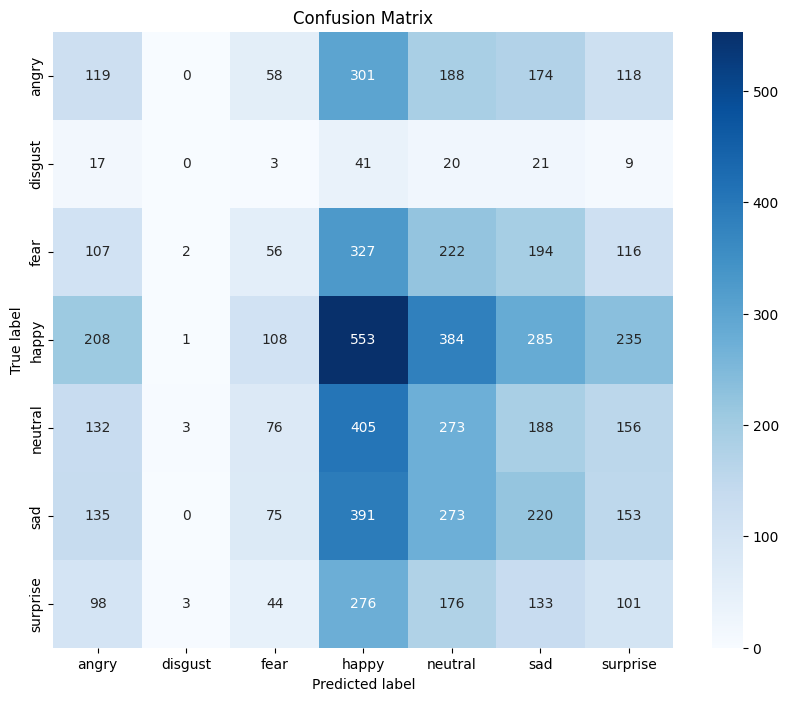

In [54]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:

               precision    recall  f1-score   support



       angry       0.15      0.12      0.13       958

     disgust       0.00      0.00      0.00       111

        fear       0.13      0.05      0.08      1024

       happy       0.24      0.31      0.27      1774

     neutral       0.18      0.22      0.20      1233

         sad       0.18      0.18      0.18      1247

    surprise       0.11      0.12      0.12       831



    accuracy                           0.18      7178

   macro avg       0.14      0.14      0.14      7178

weighted avg       0.17      0.18      0.17      7178




# Model 4 : Transfer Leanring - ResNet50

[resnet 50](https://wisdomml.in/understanding-resnet-50-in-depth-architecture-skip-connections-and-advantages-over-other-networks/)

In [56]:
train_dir = '/content/train'
test_dir = '/content/test'

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(rescale=1/255,                # Rescale pixel values to [0, 1]
                                  rotation_range=40,            # Randomly rotate images in the range (degrees, 0 to 180)
                                  width_shift_range=0.2,        # Randomly horizontally shift images
                                  height_shift_range=0.2,       # Randomly vertically shift images
                                  shear_range=0.2,              # Apply shearing transformations
                                  zoom_range=0.1,               # Randomly zoom image
                                  horizontal_flip=True,         # Randomly flip images horizontally
                                  fill_mode='nearest'           # Strategy used for filling in newly created pixels
                                )

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(
                                  rescale=1/255                 # Rescale pixel values to [0, 1]
                              )

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=32                 # Size of the batches of data
                                                )

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(224, 224),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=32                 # Size of the batches of data
                                              )

Found 28709 images belonging to 7 classes.

Found 7178 images belonging to 7 classes.


# Introducing Class wieghts for imbalanced data

In [57]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [58]:
input_shape = (224, 224, 3)

base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

model = Sequential([
                    base_model,
                    BatchNormalization(),
                    GlobalAveragePooling2D(),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(256, activation='relu'),
                    Dropout(0.1),
                    Dense(128, activation='relu'),
                    Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94668760/94668760 [==============================] - 0s 0us/step

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  

                                                                 

 batch_normalization (Batch  (None, 7, 7, 2048)        8192      

 Normalization)                                                  

                                                                 

 global_average_pooling2d (  (None, 2048)              0         

 GlobalAveragePooling2D)                                         

                                                                 

 dense_3 (Dense)             (None, 512)               1049088   

                                                                 

 dropout_2 (Dropout)         (None, 512)               0         

                                        

In [59]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [60]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=200,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=100,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                        )

Epoch 1/50

200/200 [==============================] - ETA: 0s - loss: 1.9373 - accuracy: 0.1812

Epoch 1: val_loss improved from inf to 1.90176, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras

200/200 [==============================] - 142s 552ms/step - loss: 1.9373 - accuracy: 0.1812 - val_loss: 1.9018 - val_accuracy: 0.2094

Epoch 2/50

200/200 [==============================] - ETA: 0s - loss: 1.9011 - accuracy: 0.2177

Epoch 2: val_loss improved from 1.90176 to 1.84219, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras

200/200 [==============================] - 113s 566ms/step - loss: 1.9011 - accuracy: 0.2177 - val_loss: 1.8422 - val_accuracy: 0.2534

Epoch 3/50

200/200 [==============================] - ETA: 0s - loss: 1.7788 - accuracy: 0.2664

Epoch 3: val_loss improved from 1.84219 to 1.71173, saving model to /content/FER_2013_Emotion_Detection/ResN

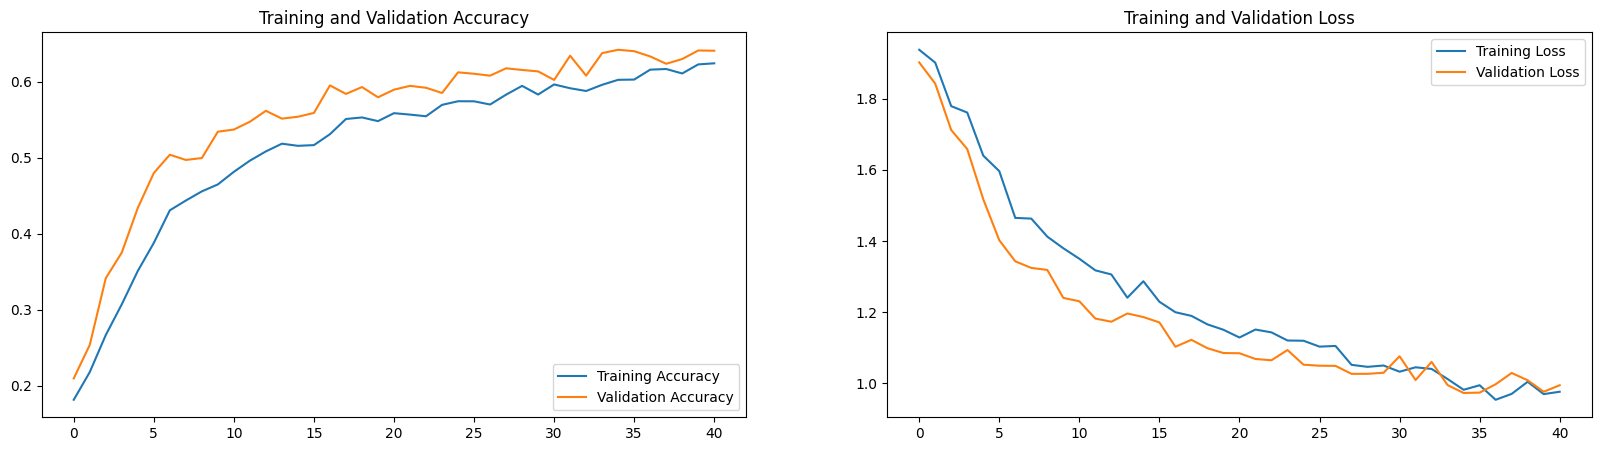

In [61]:
plot_training_history(train_history)

In [62]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

898/898 [==============================] - 373s 415ms/step - loss: 0.9750 - accuracy: 0.6350

225/225 [==============================] - 21s 92ms/step - loss: 1.0007 - accuracy: 0.6301

final train accuracy = 63.50 , validation accuracy = 63.01


225/225 [==============================] - 20s 82ms/step


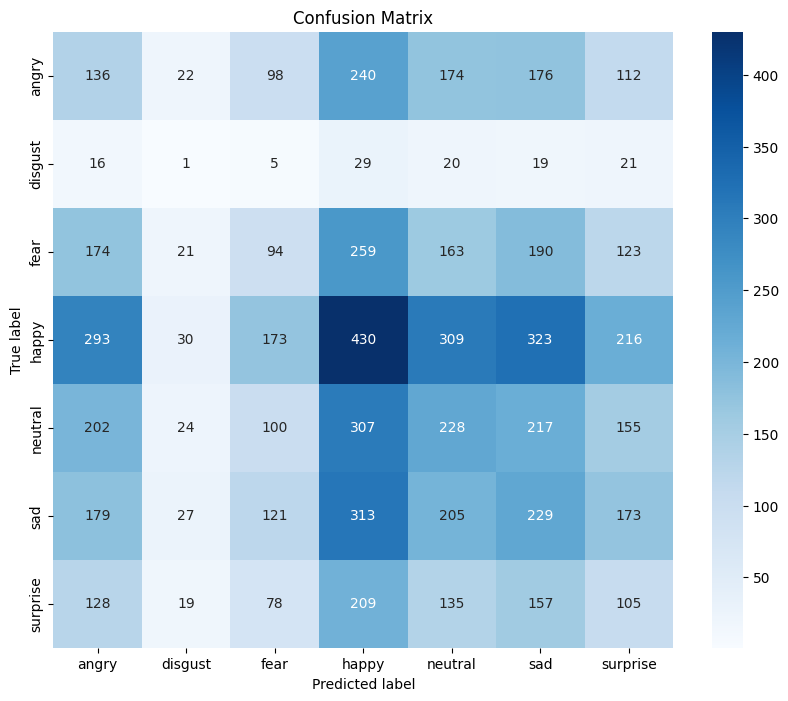

In [63]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [64]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:

               precision    recall  f1-score   support



       angry       0.12      0.14      0.13       958

     disgust       0.01      0.01      0.01       111

        fear       0.14      0.09      0.11      1024

       happy       0.24      0.24      0.24      1774

     neutral       0.18      0.18      0.18      1233

         sad       0.17      0.18      0.18      1247

    surprise       0.12      0.13      0.12       831



    accuracy                           0.17      7178

   macro avg       0.14      0.14      0.14      7178

weighted avg       0.17      0.17      0.17      7178




# AUC ROC plot for each class

In [65]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

225/225 [==============================] - 19s 83ms/step


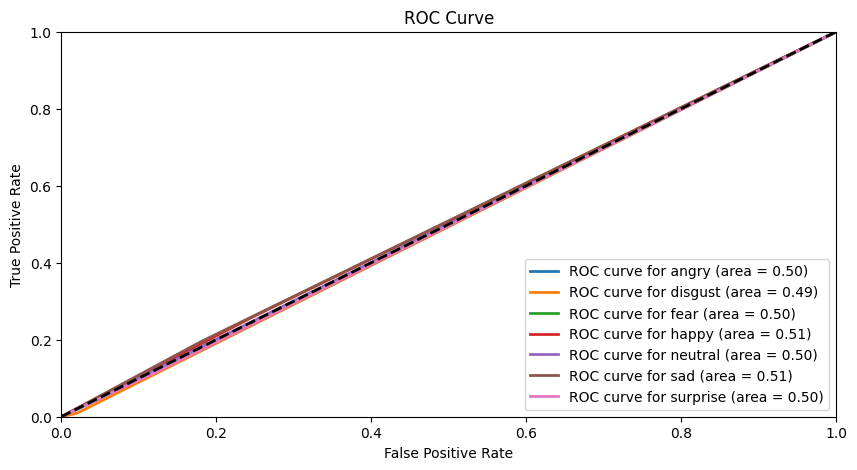

In [66]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [67]:
# Push all your models into Drive for easy access.

In [68]:
!cp /content/FER_2013_Emotion_Detection /content/drive/MyDrive/

cp: -r not specified; omitting directory '/content/FER_2013_Emotion_Detection'
